Problem statement: https://ovgu-ailab.github.io/lgm2021/ass10.html

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Number of GPUs Available: ",len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

Number of GPUs Available:  1


11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(28, 28)


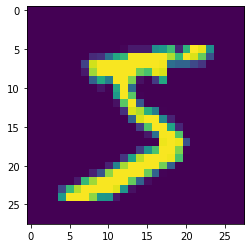

In [3]:
# Load MNIST Data set.
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(train_images.shape)
print(train_labels.shape)
print(train_images[0].shape)
#show the first image.
plt.imshow(train_images[0])

In [4]:
from sklearn.preprocessing import Binarizer
bin = Binarizer(threshold=0.5)
def reshape_img(data):
  nsamples , nx , ny = data.shape
  return data.reshape(data.shape[0], nx, ny,1).astype('float32') / 255.0

In [5]:
train_img = reshape_img(train_images)
test_img = reshape_img(test_images)
print(train_img.shape)
train_data = tf.data.Dataset.from_tensor_slices(train_img.astype(np.float32))
train_data = train_data.shuffle(buffer_size=60000).batch(128,drop_remainder=True)

print(test_img.shape)
#test_data = tf.data.Dataset.from_tensor_slices(test_img.astype(np.float32))
#test_data = test_data.shuffle(buffer_size=60000).batch(128,drop_remainder=True)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
latent_dim = 64

In [7]:
def gen_encoder(latent_dim):

  input = tf.keras.layers.Input(shape=(28, 28, 1))
  x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu',strides=(2, 2))(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D((1, 1), padding='same')(x)

  x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  encoder_output = tf.keras.layers.MaxPooling2D((1, 1), padding='same')(x)

  #print("encoder_output: ",encoder_output.shape)

  model = tf.keras.Model(inputs=input,outputs=encoder_output,name="encoder")
  model.summary()
  
  return model , encoder_output

#print("enc_shape: ",enc_shape)

In [8]:
encoder, encoder_output = gen_encoder(64)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       1280      
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0   

In [9]:
encoder.output_shape

(None, 7, 7, 64)

In [10]:
def gen_decoder(latent_dim):
  input = tf.keras.layers.Input(shape=encoder.output_shape[1:])

  x = tf.keras.layers.Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(input)
  x = tf.keras.layers.Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
  decoder_output = tf.keras.layers.Conv2DTranspose(1, 3, padding='same', activation='relu')(x)

  #print("decoder_output: ",decoder_output.shape)
  
  decoder = tf.keras.Model(inputs=input, outputs=decoder_output,name="decoder")

  decoder.summary()
  return decoder


In [11]:
decoder = gen_decoder(64)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7, 7, 64)]        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 28,001
Trainable params: 28,001
Non-trainable params: 0
_________________________________________________________________


In [12]:
decoder.output_shape

(None, 28, 28, 1)

In [13]:
def read_codebook(encodings, codebook, conv, with_inds=False):
    """
    encodings: What comes out of the encoder. 
               b x d in the fully-connected case,
               b x w x h x d in the convolutional case.
    codebook: The K x d codebook matrix.
    conv: Bool, use True for the convolutional case!
    with_inds: Bool, if True, also returns indices
    
    Returns codes, codes, and potentially indices. Why codes x2??
    - The first instance uses the straight-through estimator so that the gradients pass into the encoder.
      You should use this instance of codes to put in your decoder (for the reconstruction loss)
    - The second instance does not use this. The problem with the straight-through estimator is that it does **not**
      flow gradients into the codebook. That means we cannot use the first return value to train the codebook.
      That is why we return codes as-is as well, so we have gradients for the codebook. Use this return value for
      the codebook loss!!
    """
    if conv:
        distances = tf.reduce_mean(tf.square(encodings[:, :, :, None, :] - codebook[None, None, None, :, :]), axis=-1)
    else:
        distances = tf.reduce_mean(tf.square(encodings[:, None, :] - codebook[None, :, :]), axis=-1)
    #print("d", distances.shape)
    min_inds = tf.math.argmin(distances, axis=-1)
    #print("ind", min_inds.shape)
    codes = tf.gather(codebook, min_inds)
    
    if with_inds:
        return encodings + tf.stop_gradient(codes - encodings), codes, min_inds
    else:
        return encodings + tf.stop_gradient(codes - encodings), codes

In [14]:
def apply_ae(inp, encoder, decoder, codebook, conv, sig=False, training=False):
    # note that we return:
    # - the output (decoding) because that's what the autoencoder does :)
    # - encoder output for loss computations
    # - codebook outputs (with gradients) for loss computations
    enc = encoder(inp, training=training)
    codes, codes_with_grads = read_codebook(enc, codebook, conv=conv)
    return decoder(codes, training=training), enc, codes_with_grads

In [33]:
codebook_size = 256
dim_code = encoder.output_shape[-1]
codebook = tf.Variable(tf.random.normal([codebook_size, dim_code]))

In [34]:
epochs = 100
beta = 0.25
bce_loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(0.001)

In [36]:
def training_loop():

  for epoch in range(epochs):
    for img_batch in train_data:
      with tf.GradientTape() as tape:
        reconstruction, enc, codes = apply_ae(img_batch,
                                                  encoder,
                                                  decoder,
                                                  codebook,
                                                  conv=True,
                                                  training=True)
        
        
        commit_loss = tf.reduce_mean(tf.square(enc - tf.stop_gradient(codes)))
        code_loss = tf.reduce_mean(tf.square(tf.stop_gradient(enc) - codes))

        recons_loss = tf.reduce_mean(bce_loss(img_batch,reconstruction))
        total_loss = code_loss + recons_loss + beta * commit_loss

        grads = tape.gradient(total_loss,
                              encoder.trainable_variables +
                              decoder.trainable_variables +
                              [codebook])
        
        optimizer.apply_gradients(zip(grads,
                                  encoder.trainable_variables +
                                  decoder.trainable_variables +
                                  [codebook]))
        

    print("Epoch:{} Total_loss:{} Recons_loss:{} code_loss:{} commit_loss:{} ".format(epoch,
                                                                                      total_loss.numpy(),
                                                                                      recons_loss.numpy,
                                                                                      code_loss.numpy(),
                                                                                      commit_loss.numpy()))  


        



In [37]:
training_loop()

Epoch:0 Total_loss:0.4571523666381836 Recons_loss:<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.11501429>> code_loss:0.2737104594707489 commit_loss:0.2737104594707489 
Epoch:1 Total_loss:0.3027355670928955 Recons_loss:<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.108354844>> code_loss:0.15550458431243896 commit_loss:0.15550458431243896 
Epoch:2 Total_loss:0.2881925106048584 Recons_loss:<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.11313185>> code_loss:0.14004851877689362 commit_loss:0.14004851877689362 
Epoch:3 Total_loss:0.22370368242263794 Recons_loss:<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.10554714>> code_loss:0.09452524036169052 commit_loss:0.09452524036169052 
Epoch:4 Total_loss:0.20931638777256012 Recons_loss:<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.10305665>> code_loss:0.08500

In [41]:
codebook_size = codebook.shape
codebook_size

TensorShape([256, 64])

ValueError: ignored

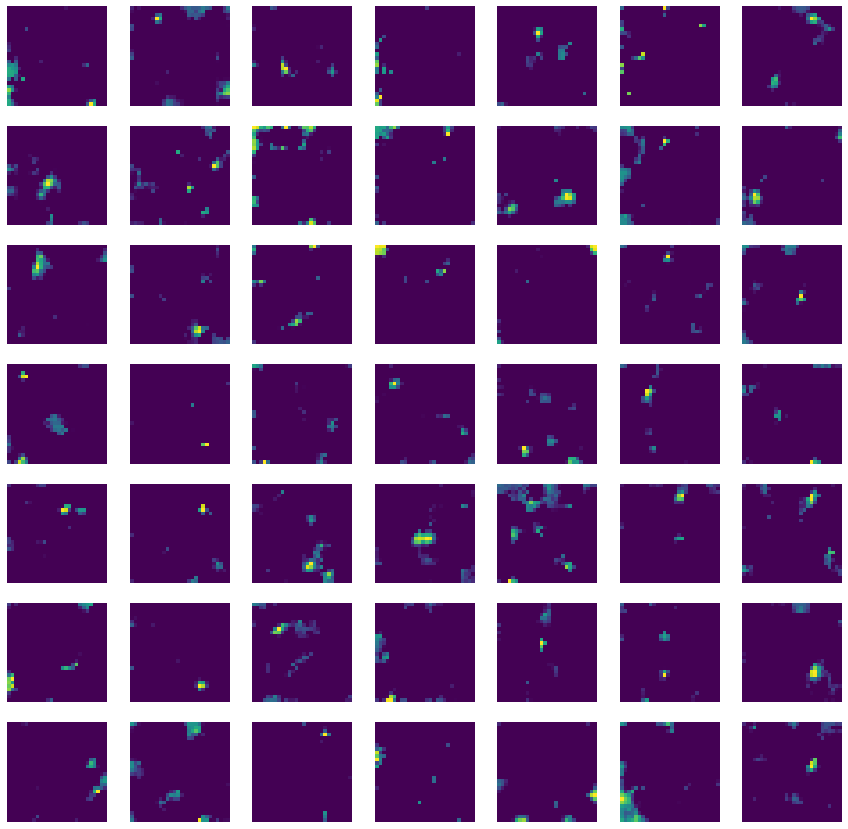

In [43]:

def noise_fn(x):
    categories = tfp.distributions.Categorical(logits=tf.zeros(codebook_size)).sample(x*7*7)
    categories = tf.reshape(categories, [-1, 7, 7])
    return tf.gather(codebook, categories)

s = decoder(noise_fn(7))
samples = tf.nn.sigmoid(s).numpy()
plt.figure(figsize=(15,15))
for ind, img in enumerate(samples):
    plt.subplot(7, 7, ind+1)
    plt.imshow(img.reshape(28,28))
    plt.axis("off")
plt.show()

In [29]:
x = img.reshape(28,28)
x.shape

(28, 28)

In [32]:
len(samples)

7000